# Oil Spill Segmentation – Inference & Visualization

This notebook demonstrates the inference and visualization pipeline
for the trained OilSpillNet model.

No training is performed here.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import cv2
import numpy as np
import matplotlib.pyplot as plt

from torchvision import models


In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

NUM_CLASSES = 6

CLASS_NAMES = [
    "Background",
    "Emulsion",
    "Oil",
    "Oil-Platform",
    "Sheen",
    "Ship"
]

IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD  = np.array([0.229, 0.224, 0.225])

TARGET_SIZE = (640, 640)


Using device: cuda


## Model Architecture

The model is a custom encoder–decoder architecture with
handcrafted attention modules, based on a modified ResNet50 backbone.


In [3]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(
            self.fc(self.avg_pool(x)) + self.fc(self.max_pool(x))
        )


class SpatialAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        max_, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg, max_], dim=1)
        return self.sigmoid(self.conv(x))


In [4]:
class ResNetEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = models.resnet50(
            weights=models.ResNet50_Weights.IMAGENET1K_V1
        )

        self.stage0 = nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool
        )
        self.stage1 = backbone.layer1
        self.stage2 = backbone.layer2
        self.stage3 = backbone.layer3
        self.stage4 = backbone.layer4

    def forward(self, x):
        x0 = self.stage0(x)
        x1 = self.stage1(x0)
        x2 = self.stage2(x1)
        x3 = self.stage3(x2)
        x4 = self.stage4(x3)
        return x1, x2, x3, x4


class DecoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
        self.ca = ChannelAttention(out_ch)
        self.sa = SpatialAttention()

    def forward(self, x):
        x = self.conv(x)
        x = self.ca(x)
        x = x * self.sa(x)
        return x


class OilSpillNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.encoder = ResNetEncoder()

        self.dec4 = DecoderBlock(2048, 512)
        self.dec3 = DecoderBlock(1024 + 512, 256)
        self.dec2 = DecoderBlock(512 + 256, 128)
        self.dec1 = DecoderBlock(256 + 128, 64)

        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        x1, x2, x3, x4 = self.encoder(x)

        d4 = F.interpolate(self.dec4(x4), size=x3.shape[2:], mode="bilinear", align_corners=False)
        d3 = F.interpolate(self.dec3(torch.cat([x3, d4], dim=1)), size=x2.shape[2:], mode="bilinear", align_corners=False)
        d2 = F.interpolate(self.dec2(torch.cat([x2, d3], dim=1)), size=x1.shape[2:], mode="bilinear", align_corners=False)
        d1 = self.dec1(torch.cat([x1, d2], dim=1))

        out = self.final(
            F.interpolate(d1, size=x.shape[2:], mode="bilinear", align_corners=False)
        )
        return out


In [5]:
MODEL_PATH = "/kaggle/input/finall-model/pytorch/default/1/finall_model (1).pth" 
model = OilSpillNet(NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

print("Model loaded successfully")


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 221MB/s]


Model loaded successfully


In [6]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


In [7]:
import matplotlib.patches as mpatches

CLASS_NAMES = [
    "Background",
    "Emulsion",
    "Oil",
    "Oil-Platform",
    "Sheen",
    "Ship"
]

CLASS_COLORS = {
    0: (0, 0, 0),        # Background - Black
    1: (0, 255, 0),      # Emulsion - Green
    2: (255, 0, 0),      # Oil - Red
    3: (0, 0, 255),      # Oil-Platform - Blue
    4: (255, 255, 0),    # Sheen - Yellow
    5: (255, 0, 255),    # Ship - Magenta
}


In [8]:
def mask_to_rgb(mask):
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)

    for cls_id, color in CLASS_COLORS.items():
        rgb[mask == cls_id] = color

    return rgb


In [9]:
def visualize_with_labels(image, mask):
    mask_rgb = mask_to_rgb(mask)

    overlay = image.copy()
    alpha = 0.5
    overlay[mask > 0] = (
        overlay[mask > 0] * (1 - alpha) +
        mask_rgb[mask > 0] * alpha
    ).astype(np.uint8)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(mask_rgb)
    axes[1].set_title("Predicted Mask")
    axes[1].axis("off")

    axes[2].imshow(overlay)
    axes[2].set_title("Overlay + Labels")
    axes[2].axis("off")

    # Legend
    patches = [
        mpatches.Patch(
            color=np.array(CLASS_COLORS[i]) / 255,
            label=CLASS_NAMES[i]
        )
        for i in np.unique(mask)
    ]

    axes[2].legend(
        handles=patches,
        bbox_to_anchor=(1.05, 1),
        loc="upper left"
    )

    plt.tight_layout()
    plt.show()


In [10]:
def print_class_percentages(mask):
    total_pixels = mask.size
    print("Class distribution:")
    for i, name in enumerate(CLASS_NAMES):
        pct = (mask == i).sum() / total_pixels * 100
        print(f"{name:15s}: {pct:.2f}%")


In [12]:
def infer_single_image(image_path):
    model.eval()

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    original = img.copy()
    h, w, _ = original.shape

    img = cv2.resize(img, TARGET_SIZE)
    img = img / 255.0
    img = (img - IMAGENET_MEAN) / IMAGENET_STD

    img = torch.from_numpy(img).permute(2,0,1).float().unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        out = model(img)
        pred = torch.argmax(out, dim=1)[0].cpu().numpy()

    pred = cv2.resize(pred.astype(np.uint8), (w, h), interpolation=cv2.INTER_NEAREST)

    return original, pred


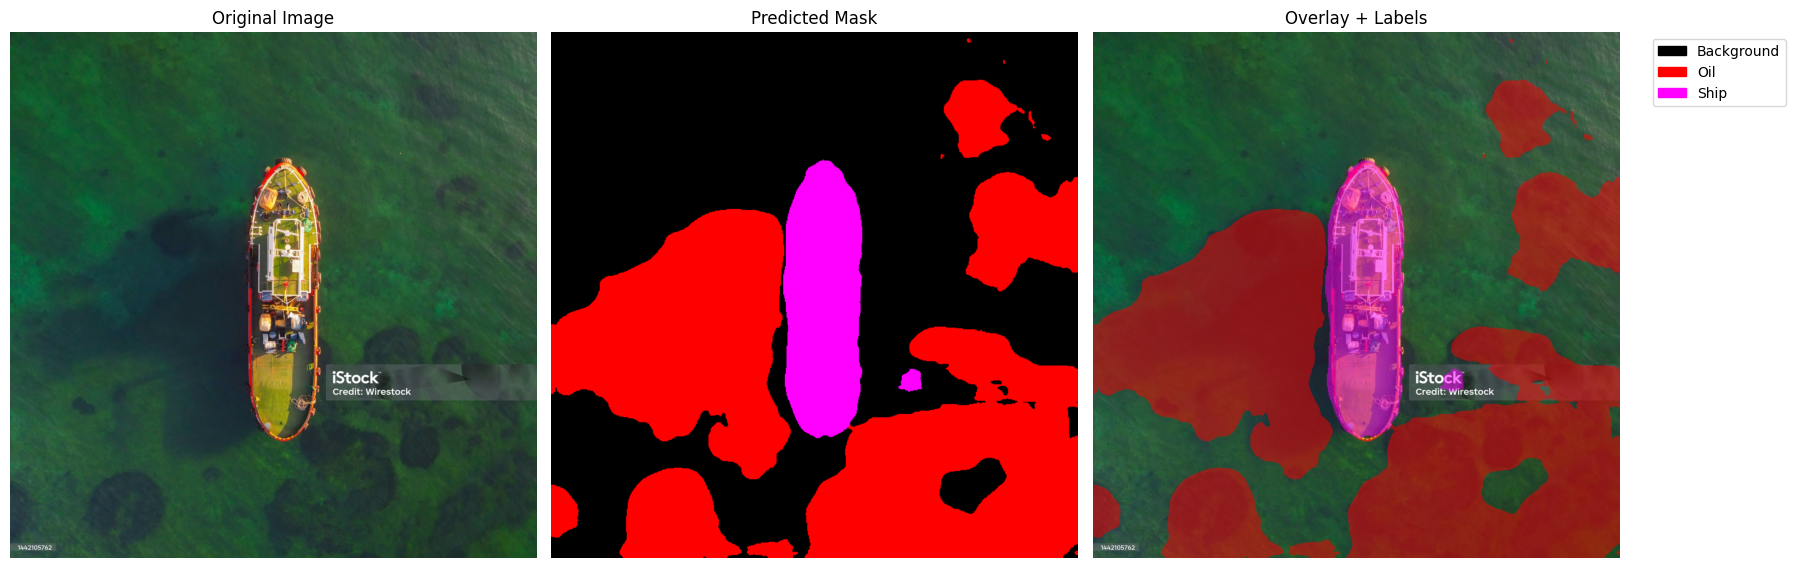

Class distribution:
Background     : 55.12%
Emulsion       : 0.00%
Oil            : 38.10%
Oil-Platform   : 0.00%
Sheen          : 0.00%
Ship           : 6.78%


In [13]:
image, mask = infer_single_image("/kaggle/input/test-4/WhatsApp Image 2025-12-27 at 4.01.18 PM.jpeg")
visualize_with_labels(image, mask)
print_class_percentages(mask)


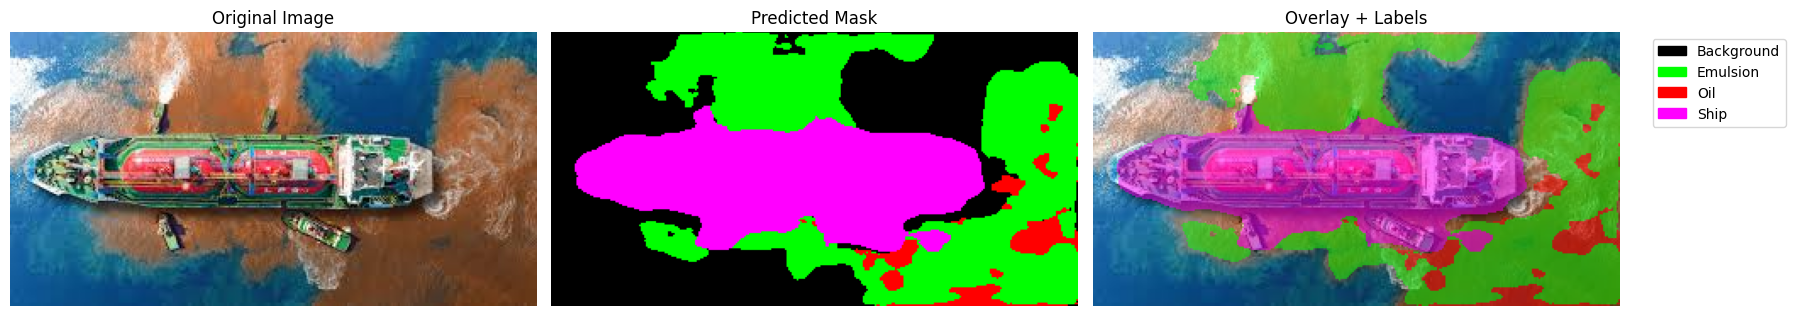

Class distribution:
Background     : 38.71%
Emulsion       : 31.69%
Oil            : 3.56%
Oil-Platform   : 0.00%
Sheen          : 0.00%
Ship           : 26.04%


In [15]:
image, mask = infer_single_image("/kaggle/input/test-2/download (1).jpg")
visualize_with_labels(image, mask)
print_class_percentages(mask)


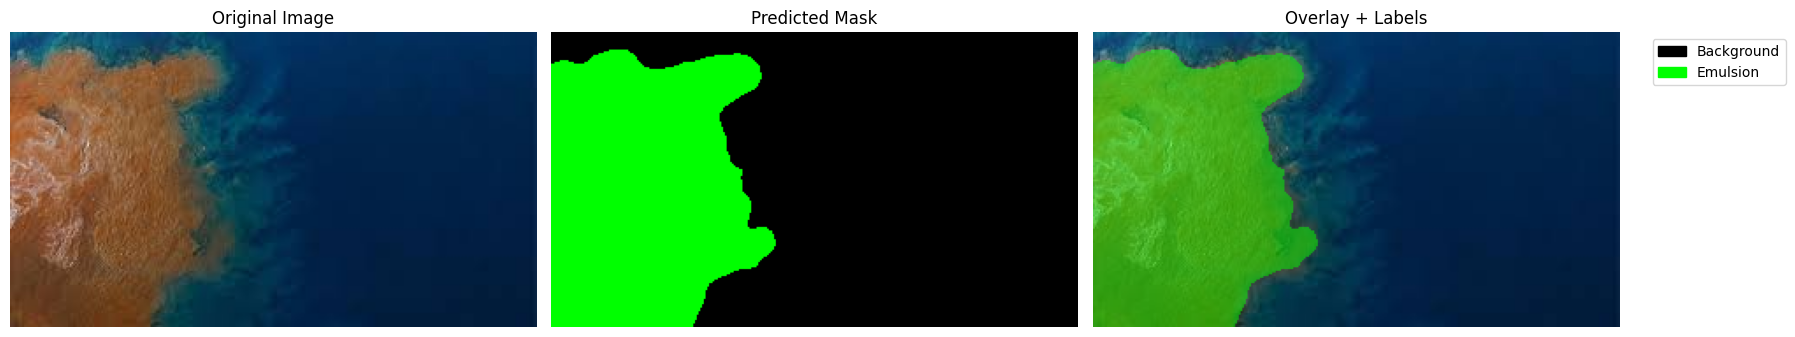

Class distribution:
Background     : 67.84%
Emulsion       : 32.16%
Oil            : 0.00%
Oil-Platform   : 0.00%
Sheen          : 0.00%
Ship           : 0.00%


In [16]:
image, mask = infer_single_image("/kaggle/input/test-3/images.jpg")
visualize_with_labels(image, mask)
print_class_percentages(mask)


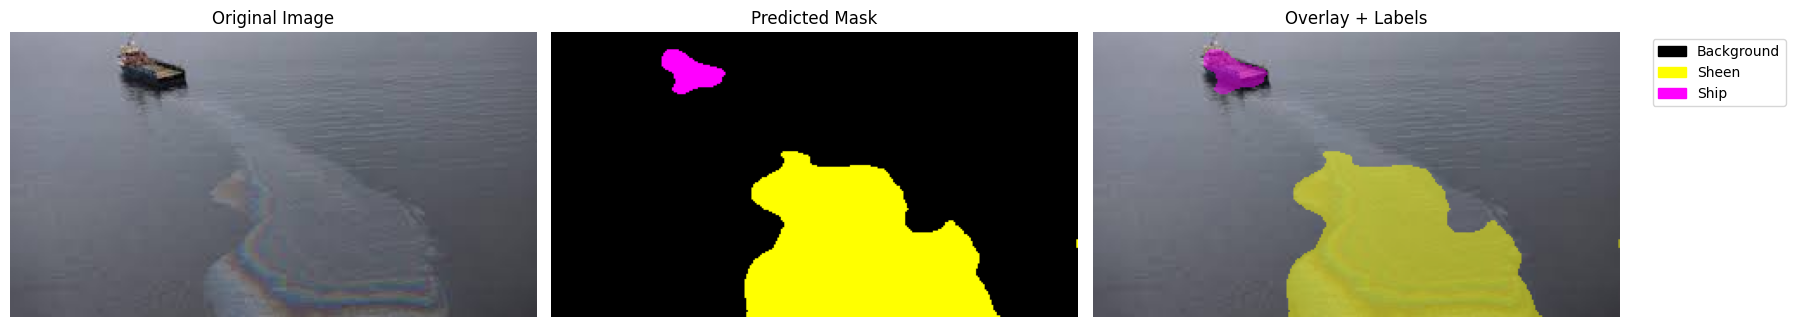

Class distribution:
Background     : 79.79%
Emulsion       : 0.00%
Oil            : 0.00%
Oil-Platform   : 0.00%
Sheen          : 19.11%
Ship           : 1.10%


In [17]:
image, mask = infer_single_image("/kaggle/input/testing-2/images (1).jpg")
visualize_with_labels(image, mask)
print_class_percentages(mask)


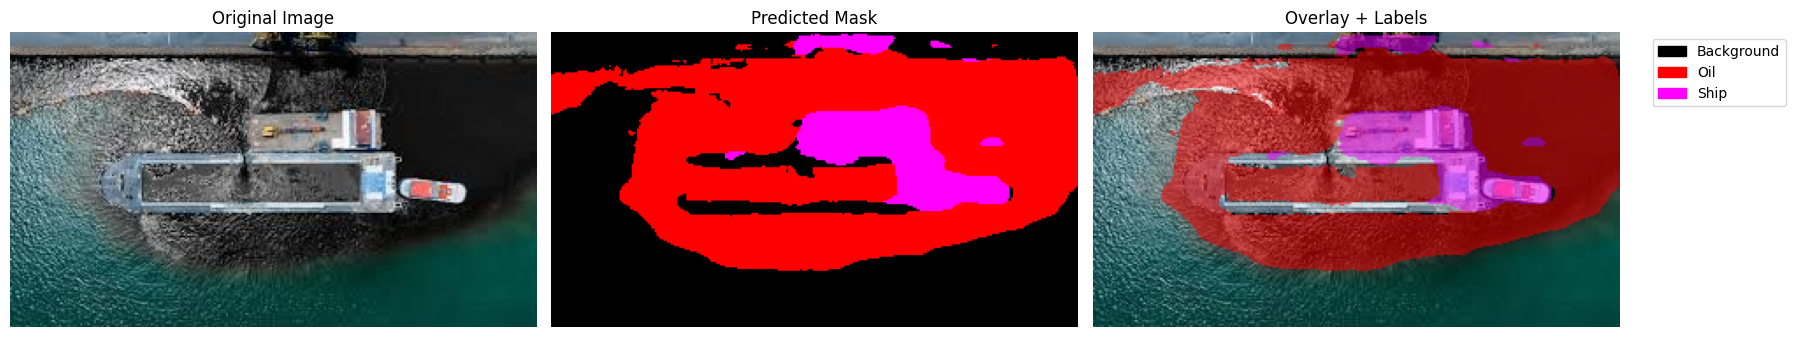

Class distribution:
Background     : 47.09%
Emulsion       : 0.00%
Oil            : 44.68%
Oil-Platform   : 0.00%
Sheen          : 0.00%
Ship           : 8.23%


In [18]:
image, mask = infer_single_image("/kaggle/input/testing-3/images (3).jpg")
visualize_with_labels(image, mask)
print_class_percentages(mask)


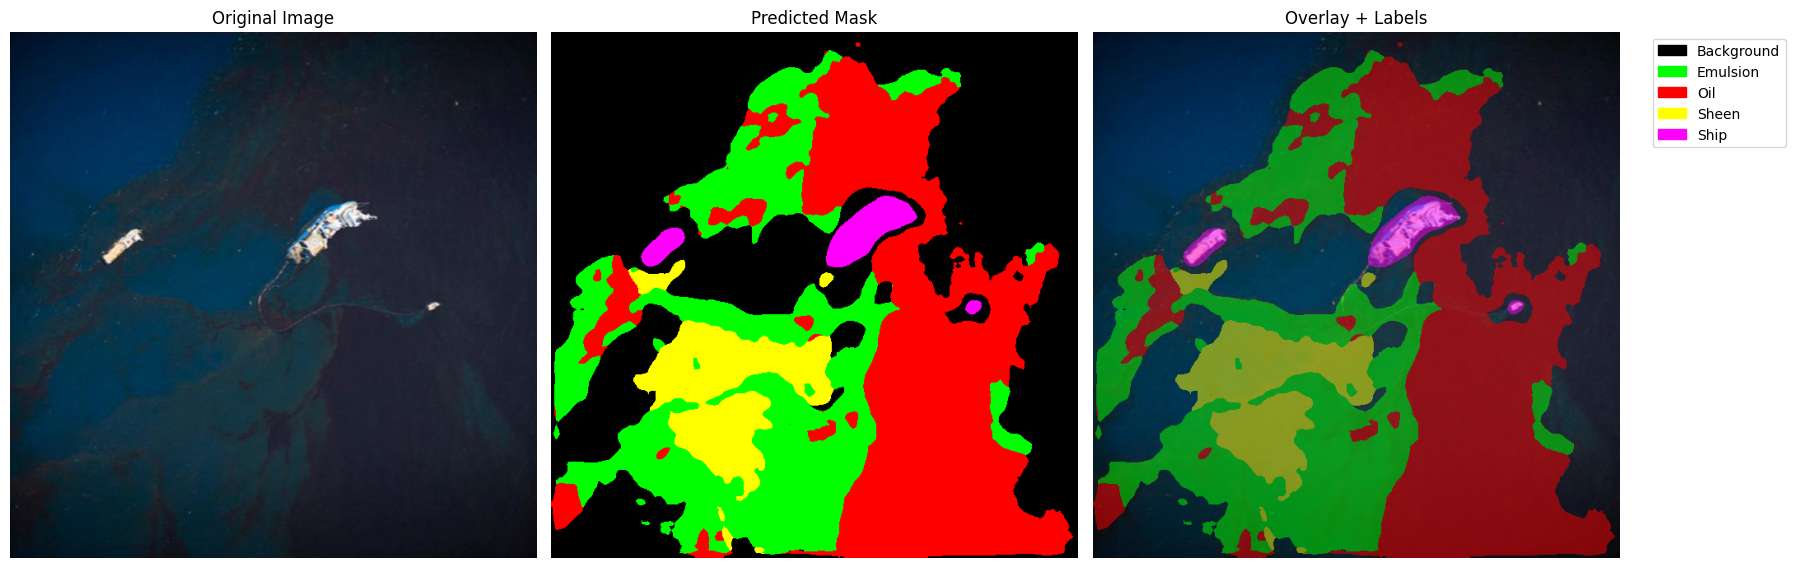

Class distribution:
Background     : 46.91%
Emulsion       : 19.97%
Oil            : 25.19%
Oil-Platform   : 0.00%
Sheen          : 6.36%
Ship           : 1.57%


In [21]:
image, mask = infer_single_image("/kaggle/input/oil-spill-raw-segmentation/test/05_73_jpg.rf.f0da9f29ff04c086fe8a1fd9de6e8c8e.jpg")
visualize_with_labels(image, mask)
print_class_percentages(mask)


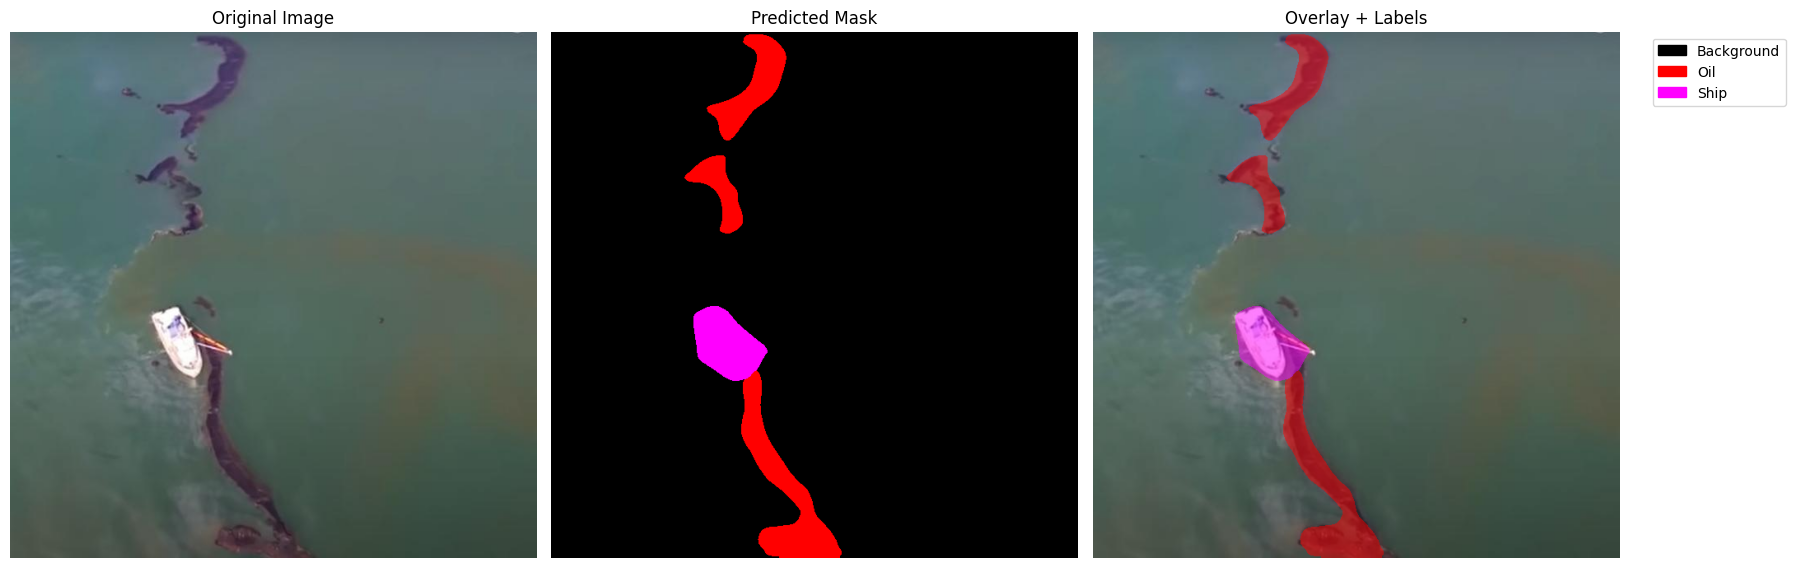

Class distribution:
Background     : 94.79%
Emulsion       : 0.00%
Oil            : 3.90%
Oil-Platform   : 0.00%
Sheen          : 0.00%
Ship           : 1.31%


In [23]:
image, mask = infer_single_image("/kaggle/input/oil-spill-raw-segmentation/test/1012_jpg.rf.9526998b587bbb21282da1bbc9f25c65.jpg")
visualize_with_labels(image, mask)
print_class_percentages(mask)


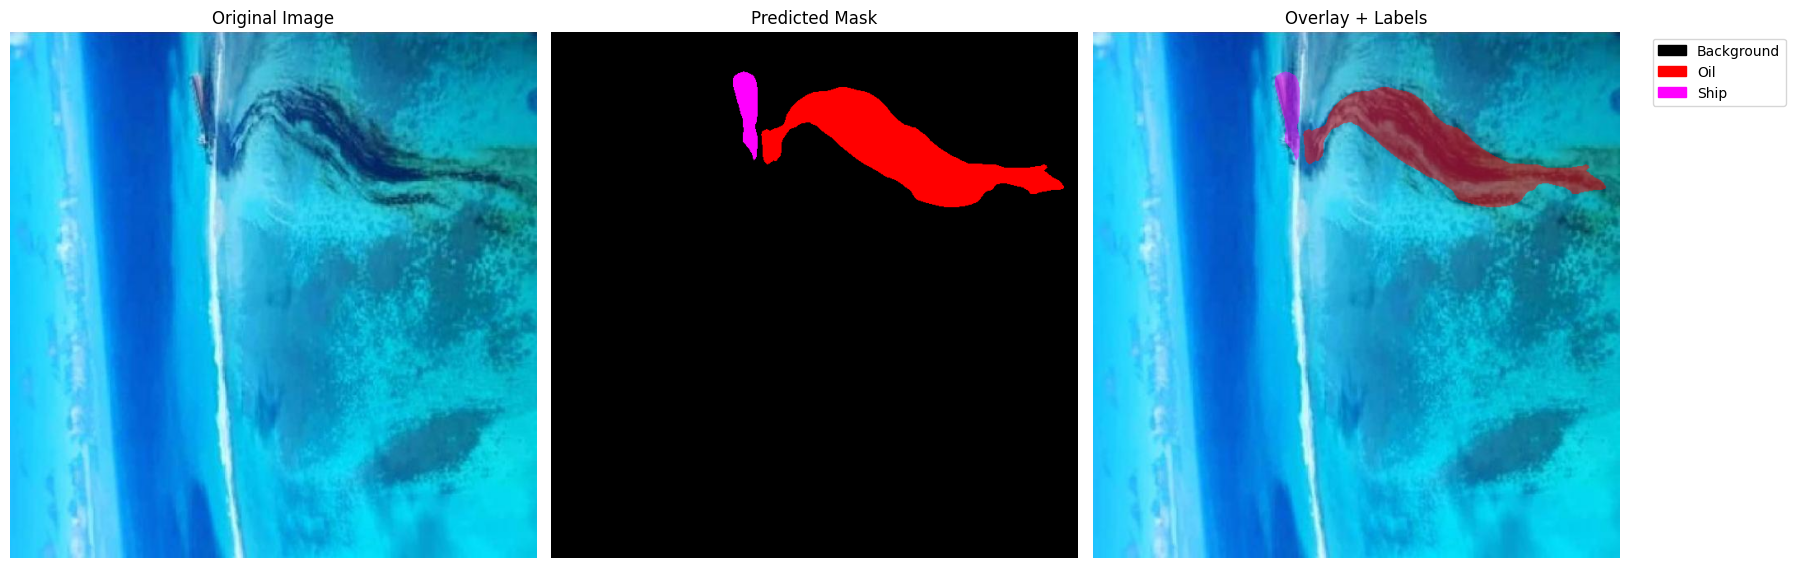

Class distribution:
Background     : 94.88%
Emulsion       : 0.00%
Oil            : 4.62%
Oil-Platform   : 0.00%
Sheen          : 0.00%
Ship           : 0.50%


In [25]:
image, mask = infer_single_image("/kaggle/input/oil-spill-raw-segmentation/test/116791527_673230759936707_1908557071451096224_n_jpg.rf.acea52eb719896b16f6b945ec0a87f6b.jpg")
visualize_with_labels(image, mask)
print_class_percentages(mask)


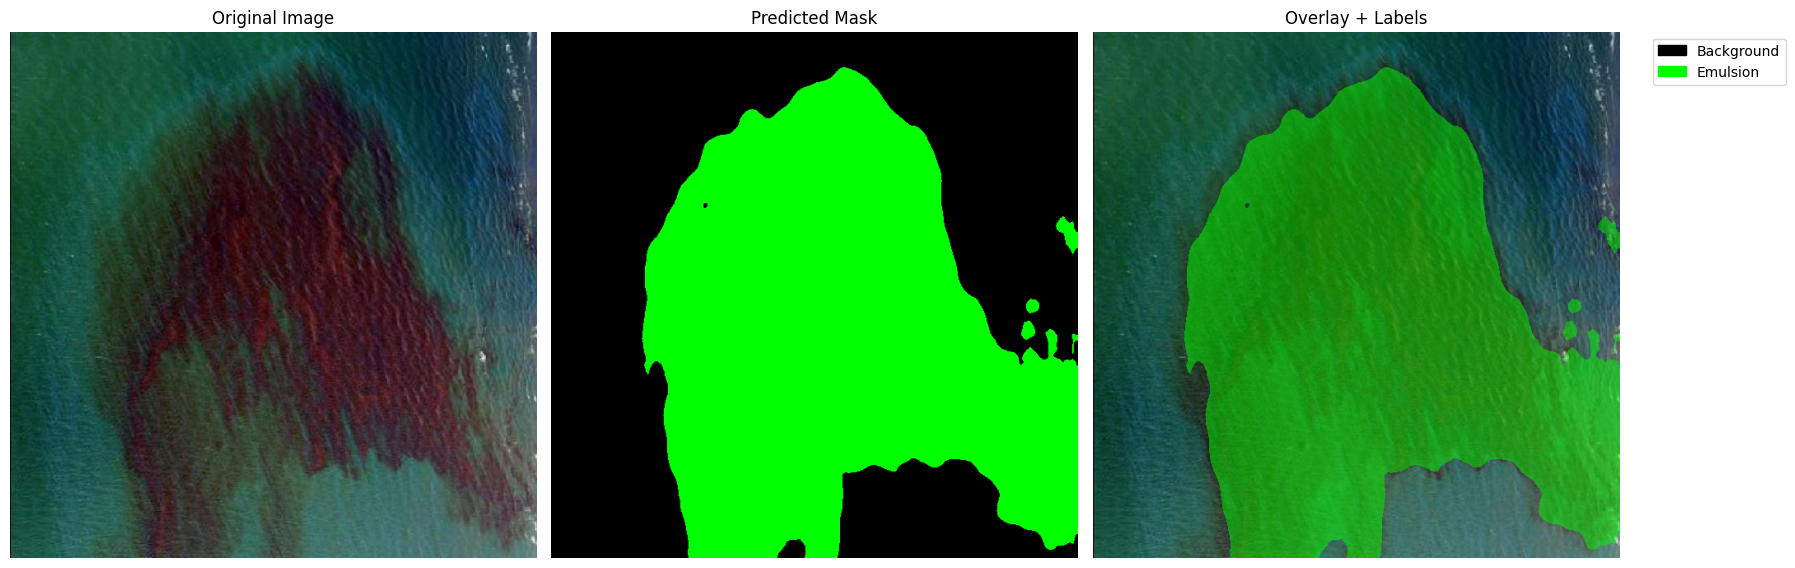

Class distribution:
Background     : 50.13%
Emulsion       : 49.87%
Oil            : 0.00%
Oil-Platform   : 0.00%
Sheen          : 0.00%
Ship           : 0.00%


In [28]:
image, mask = infer_single_image("/kaggle/input/oil-spill-raw-segmentation/test/101300494-jpg-0_jpg.rf.a76b46929d9be60513a41572faed52ae.jpg")
visualize_with_labels(image, mask)
print_class_percentages(mask)


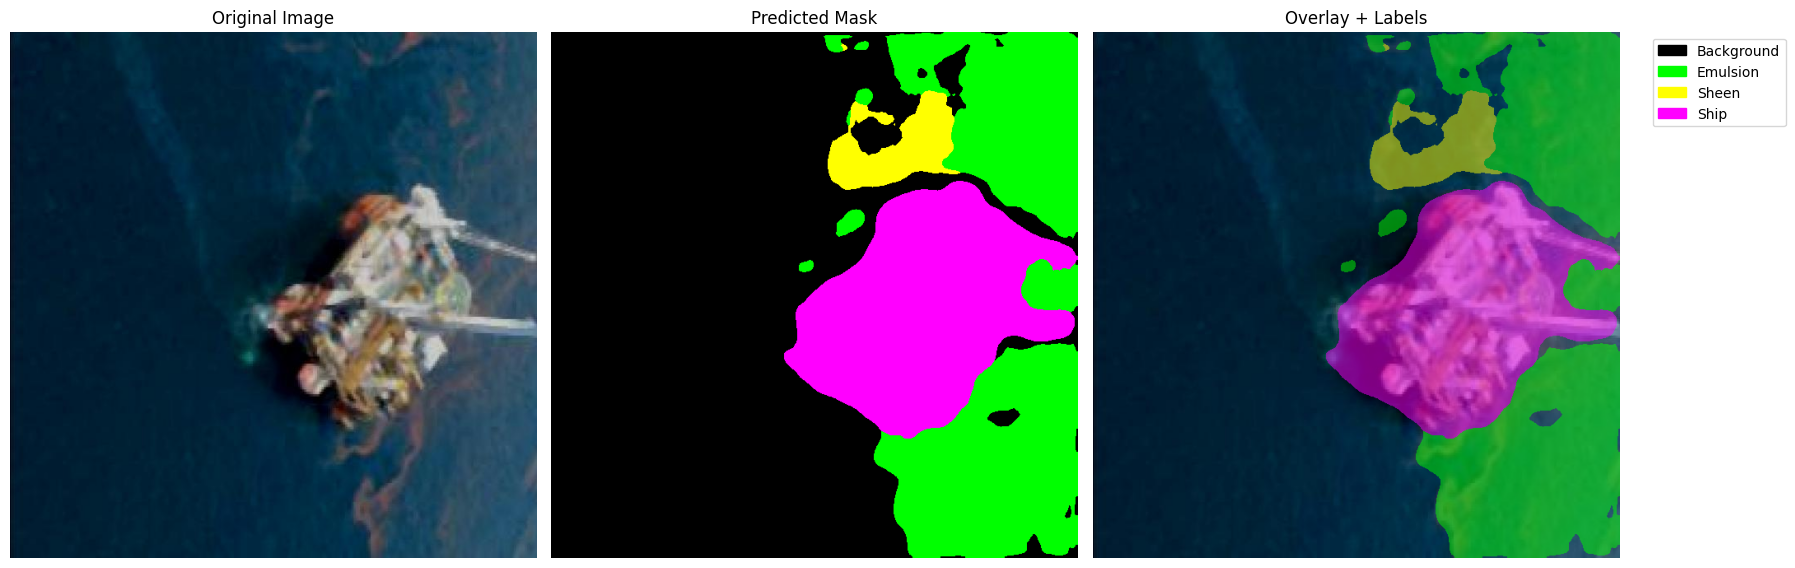

Class distribution:
Background     : 60.73%
Emulsion       : 21.18%
Oil            : 0.00%
Oil-Platform   : 0.00%
Sheen          : 2.57%
Ship           : 15.53%


In [29]:
image, mask = infer_single_image("/kaggle/input/oil-spill-raw-segmentation/test/10_jpg.rf.81a61c1c2a2734bd8e02bbaf07dbabad.jpg")
visualize_with_labels(image, mask)
print_class_percentages(mask)


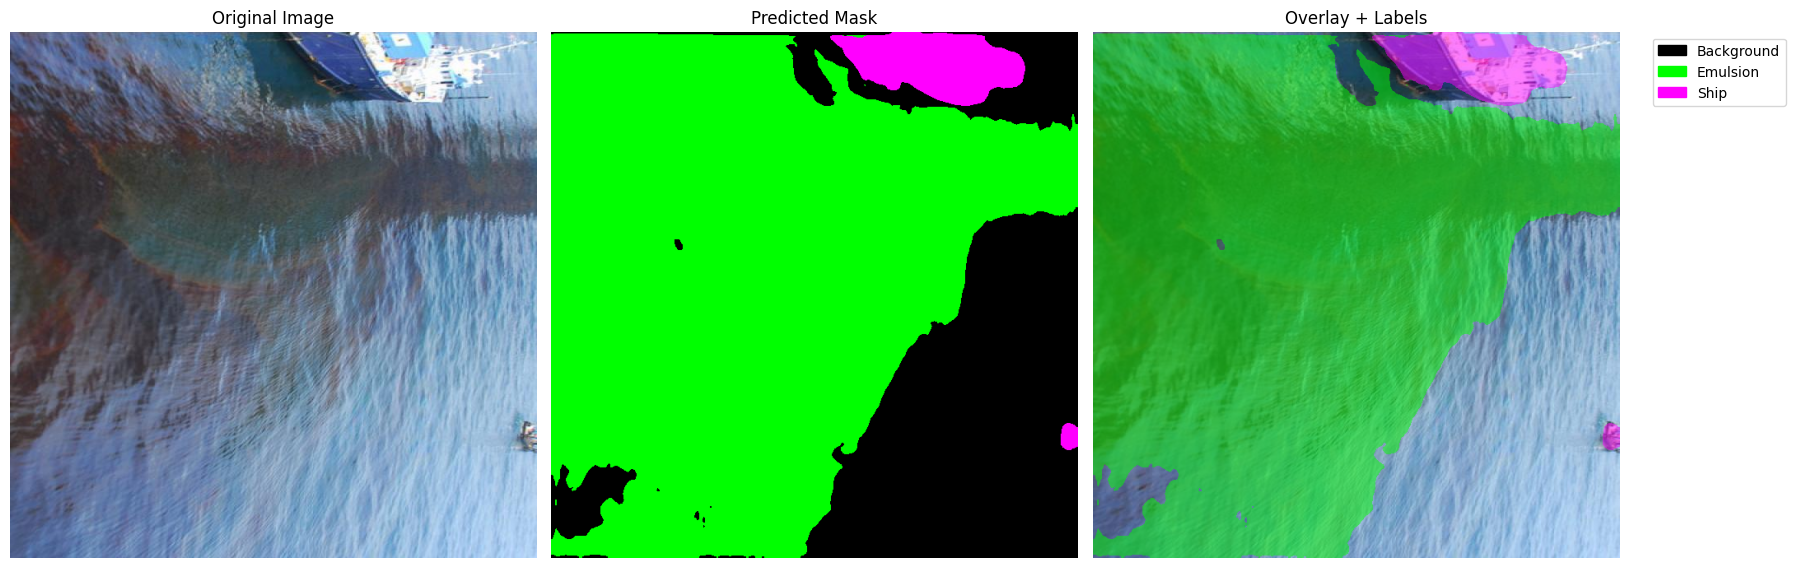

Class distribution:
Background     : 28.77%
Emulsion       : 67.64%
Oil            : 0.00%
Oil-Platform   : 0.00%
Sheen          : 0.00%
Ship           : 3.59%


In [30]:
image, mask = infer_single_image("/kaggle/input/oil-spill-raw-segmentation/test/1116-jan11-815x400-1-_jpg.rf.9d3f7ac026b2ce6c52602b295307d8bc.jpg")
visualize_with_labels(image, mask)
print_class_percentages(mask)


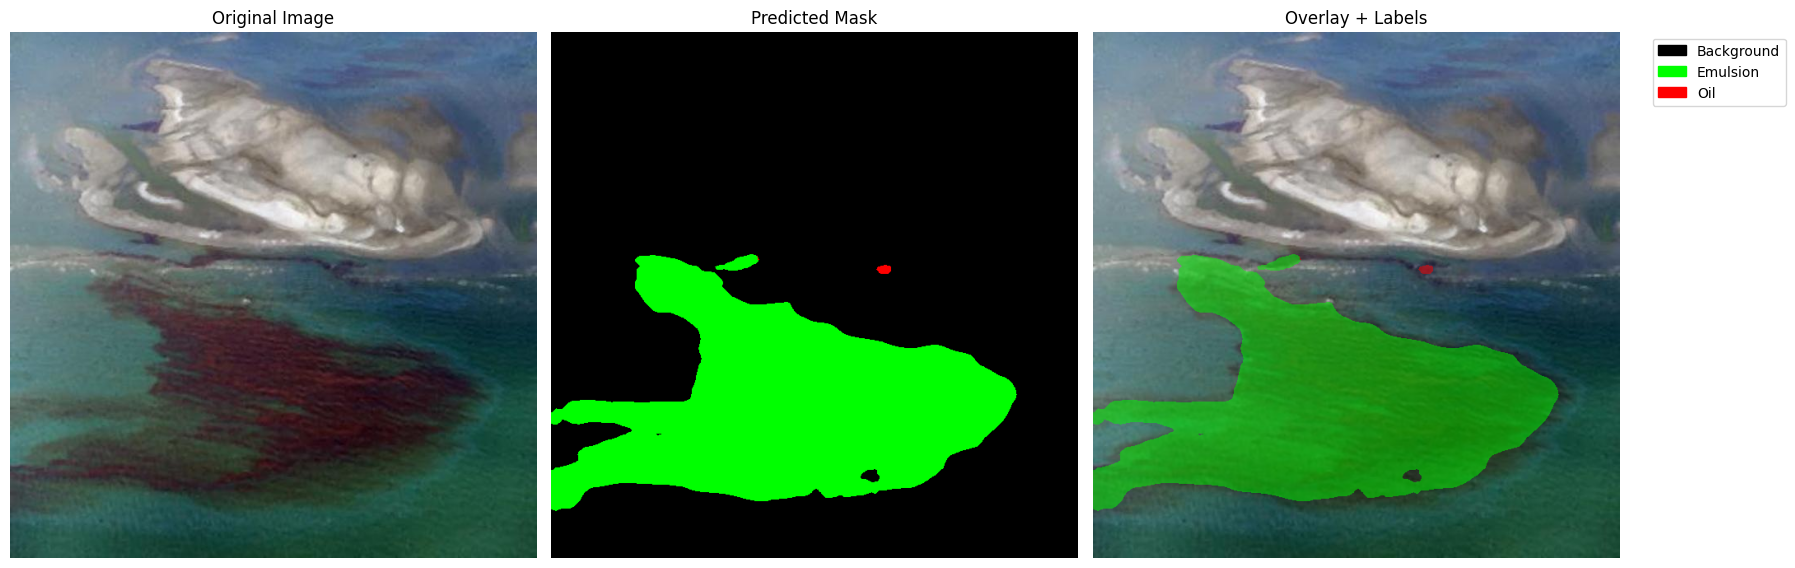

Class distribution:
Background     : 77.48%
Emulsion       : 22.49%
Oil            : 0.04%
Oil-Platform   : 0.00%
Sheen          : 0.00%
Ship           : 0.00%


In [33]:
image, mask = infer_single_image("/kaggle/input/oil-spill-raw-segmentation/test/101300494-jpg-0_jpg.rf.1b65dc59f0296aadfcbf56010bdccc02.jpg")
visualize_with_labels(image, mask)
print_class_percentages(mask)


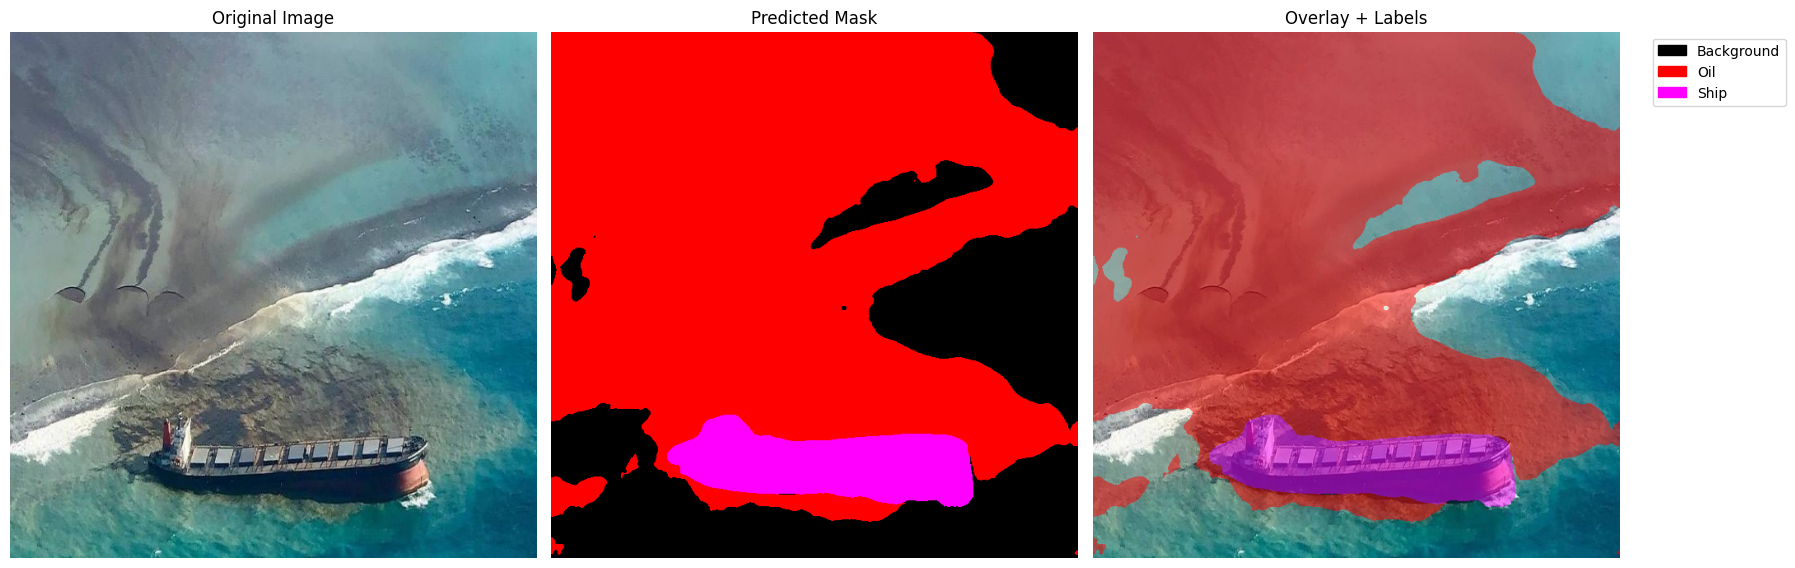

Class distribution:
Background     : 28.67%
Emulsion       : 0.00%
Oil            : 64.83%
Oil-Platform   : 0.00%
Sheen          : 0.00%
Ship           : 6.50%


In [32]:
image, mask = infer_single_image("/kaggle/input/oil-spill-raw-segmentation/test/117293683_775752963195785_5574102870762797298_n_jpg.rf.279ba46a1aae3623f556538bf6ae0360.jpg")
visualize_with_labels(image, mask)
print_class_percentages(mask)
